In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


In [ ]:
!pip install --upgrade scikit-learn==1.3.2 imbalanced-learn==0.11.0

In [2]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.width', None)        
pd.set_option('display.expand_frame_repr', False)

In [4]:
trans_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
identity_data = pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_recall_curve,roc_curve, auc
from sklearn.preprocessing import TargetEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier

In [7]:
Y = trans_data['isFraud'].copy()
x_cols = [c for c in trans_data.columns if c != 'isFraud']
x_data = trans_data[x_cols].copy()
x_train, T_x, y_train, T_y = train_test_split(x_data, Y,test_size = 0.2, random_state=42) 
x_val, x_test, y_val, y_test = train_test_split(T_x, T_y,test_size = 0.5, random_state=42)

In [8]:
from sklearn.base import BaseEstimator, TransformerMixin

class MyImputer(BaseEstimator,TransformerMixin):
    def __init__(self,strategy:str = 'most_frequent'):
        self.imputer = None
        self.strategy = strategy

    def fit(self, x, y=None):
        x_copy = x.copy()
        self.imputer = SimpleImputer(strategy=self.strategy)
        self.imputer.fit(x_copy)
        return self

    def transform(self, x):
        x_transformed = x.copy()
        ret_val = pd.DataFrame(self.imputer.transform(x),columns=x_transformed.columns)

        return ret_val.astype(x_transformed.dtypes)

In [10]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import TargetEncoder

class MyTargetEncoder(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.encoder = TargetEncoder(smooth="auto")
        self.target_cols = []
    
    def fit(self, X:pd.DataFrame, y=None):
        self.target_cols = [c for c in X.columns if X[c].dtype == 'object']
        self.encoder.fit(X[self.target_cols].copy(),y)
        return self

    def transform(self, X):
        x_copy = X.copy()
        x_copy[self.target_cols] = self.encoder.transform(x_copy[self.target_cols])
        return x_copy

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class Scaler(BaseEstimator,TransformerMixin):
    def __init__(self, scaler = StandardScaler()):
        self.scaler = scaler
        self.num_cols = []

    def fit(self, X:pd.DataFrame, y=None):
        if self.scaler == None:
            return self
        self.num_cols = [c for c in X if X[c].dtype != 'object']
        df_copy = X[self.num_cols].copy()
        
        self.scaler.fit(X[self.num_cols].copy())
        return self

    def transform(self, X):
        X_copy = X.copy()
        if self.scaler == None:
            return X_copy
        X_copy[self.num_cols] = pd.DataFrame(self.scaler.transform(X_copy[self.num_cols]),columns=self.num_cols)
        return X_copy

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

class NaHeavy(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.drop_cols = []

    def fit(self, x, y=None):
        self.drop_cols = [c for c in x.columns if x[c].isna().sum() > x.shape[0]*self.threshold]
        return self

    def transform(self, x):
        print(f'Na dropped {len(self.drop_cols)} features')
        return x.drop(columns = self.drop_cols)

In [15]:
from sklearn.base import BaseEstimator, TransformerMixin

class CorrelationFilter(BaseEstimator,TransformerMixin):
    def __init__(self, threshold:int = 0.7):
        self.threshold = threshold
        self.features_to_drop = []

    def fit(self, X:pd.DataFrame, y):
        num_cols = [c for c in X.columns if X[c].dtype != 'object']
        X_copy = X[num_cols].copy()
        X_copy['target'] = y
        corr_matrix = X_copy.corr().abs()

        target_cor = corr_matrix.pop('target')
        corr_matrix.drop(labels='target', axis=0,inplace=True)
        
        high_corr_pairs = []

        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                if corr_matrix.iloc[i, j] > self.threshold:
                    high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_matrix.iloc[i, j]))


        features_to_drop = set()
        for feat1, feat2, _ in high_corr_pairs:
            if target_cor[feat1] < target_cor[feat2]:
                features_to_drop.add(feat1)
            else:
                features_to_drop.add(feat2)
        self.features_to_drop = list(features_to_drop)
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        print('corr dropped: ',len(self.features_to_drop))
        return X_copy.drop(columns=self.features_to_drop)

In [16]:
from sklearn.base import BaseEstimator, TransformerMixin

class VarianceFilter(BaseEstimator,TransformerMixin):
    def __init__(self, left_threshold:float = 0.003, right_threshold:float=50.00):
        self.left_threshold = left_threshold
        self.right_threshold = right_threshold
        self.drop_features = []

    def fit(self, X:pd.DataFrame, y):
        num_values = [c for c in X.columns if X[c].dtype != 'object']
        l = []

        for c in X.columns:
            counts = X[c].value_counts()
            all_c = X.shape[0]-X[c].isna().sum()
            if ((float(max(counts))/float(all_c)*100.00) > self.right_threshold or 
                (float(max(counts))/float(all_c)*100.00) < self.left_threshold):
                l.append(c)
        
        self.drop_features = l
        return self

    def transform(self, X:pd.DataFrame):
        X_copy = X.copy()
        print('var dropped : ',len(self.drop_features))
        return X_copy.drop(columns=self.drop_features)

In [17]:
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin
class CustomRFE(BaseEstimator,TransformerMixin):
    def __init__(self, feature_to_select):
        self.feature_to_select = feature_to_select
        self.rfe = RFE(
            estimator=XGBClassifier(max_depth=40,reg_lambda=10),
            n_features_to_select=feature_to_select,
        )
        self.dropped_features = []
        self.selected_features = []

    def fit(self, X:pd.DataFrame, y=None):
        self.rfe.fit(X.copy(),y.copy())

        cols = X.columns
        selected = self.rfe.support_

        # Get selected and dropped features
        self.selected_features = cols[selected]
        self.dropped_features = cols[~selected]

        return self

    def transform(self, X):
        X_copy = X.copy()
        print('rfe dropped: ',len(self.dropped_features))
        res = X_copy[self.selected_features]
        return res

    def get_features()-> list[str]:
        return self.dropped_features

In [57]:
pipeline = Pipeline(steps=[
        # ('slector', CustomSelector()),
        ('naheavy', NaHeavy(0.9)),
        ('var_filter', VarianceFilter(0.00, 85.00)),
        ('imputer', MyImputer()),
        ('corr',CorrelationFilter(0.98)),
        # ('cat2num', CatToNum(5)),
        ('cat2num', MyTargetEncoder()),
        ('scaler', Scaler()),
        # ('logistic_filter',LogisticFilter(0.015)),
        ('model', DecisionTreeClassifier(random_state=42, max_depth=50,min_samples_split=60))
    ])

imb_pipeline = ImbPipeline(steps=[
    ('undersampler', RandomUnderSampler(random_state=42, sampling_strategy=0.1)),
    ('oversampler', RandomOverSampler(random_state=42, sampling_strategy=0.40))
])

In [50]:
x_train_sampled, y_train_resampled = imb_pipeline.fit_resample(x_train,y_train)

In [51]:
prep = Pipeline(steps=pipeline.steps[:-1])

In [53]:
prep_model = prep.fit(x_train_sampled, y_train_resampled)

Na dropped 1 features
var dropped :  156
corr dropped:  37


In [54]:
proccesed_sample = prep_model.transform(x_train_sampled)
procesed_train = prep_model.transform(x_train)
processed_val = prep_model.transform(x_val)

Na dropped 1 features
var dropped :  156
corr dropped:  37
Na dropped 1 features
var dropped :  156
corr dropped:  37
Na dropped 1 features
var dropped :  156
corr dropped:  37


In [56]:
params_max_depth = [20,30,40,50]
min_sample_split = [20,35,50,60]
for p in params_max_depth:
    for p1 in min_sample_split:
        c = Pipeline(steps=[
            # ('slector', CustomSelector()),
            # ('naheavy', NaHeavy(p)),
            # ('var_filter', VarianceFilter(0.00, 85.00)),
            # ('imputer', MyImputer()),
            # ('corr',CorrelationFilter(0.98)),
            # ('cat2num', CatToNum(p)),
            # ('scaler', Scaler()),
            # ('logistic_filter',LogisticFilter(0.015)),
            ('model', DecisionTreeClassifier(random_state=42, max_depth=p,min_samples_split=p1))
        ])
        
        # c = Pipeline(steps=[
        #     # ('rfe', CustomRFE(340)),
        #     ('xgb',XGBClassifier(max_depth=40,reg_lambda=10))
        # ]) 
        
        
        mod = c.fit(proccesed_sample,y_train_resampled)
        train_proba = mod.predict_proba(procesed_train)
        val_proba = mod.predict_proba(processed_val)
    
        val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
        val_roc_auc = auc(val_fpr, val_tpr)
    
        val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
        val_auc_pr = auc(val_recall, val_precision)
    
        train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
        train_roc_auc = auc(train_fpr, train_tpr)
    
        train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
        train_auc_pr = auc(train_recall, train_precision)
        print('p: p1:',p,p1)
        print('val_roc: ',val_roc_auc)
        print('val_pr: ', val_auc_pr)
        print('train_roc: ', train_roc_auc)
        print('train_pr: ', train_auc_pr)
        print('##############################')

p: p1: 20 20
val_roc:  0.8158745542281309
val_pr:  0.4136214504942912
train_roc:  0.9644489692031926
train_pr:  0.6387910479197788
##############################
p: p1: 20 35
val_roc:  0.834944430079641
val_pr:  0.4313941320006853
train_roc:  0.960911051554632
train_pr:  0.6392681849355241
##############################
p: p1: 20 50
val_roc:  0.8455650468677682
val_pr:  0.4424486894262392
train_roc:  0.9572887656788653
train_pr:  0.6340536520748074
##############################
p: p1: 20 60
val_roc:  0.8503525469301156
val_pr:  0.4450500820196672
train_roc:  0.9551248287049887
train_pr:  0.6290127453442157
##############################
p: p1: 30 20
val_roc:  0.8067953437917457
val_pr:  0.44446402781006805
train_roc:  0.9842026899503833
train_pr:  0.7290629899149849
##############################
p: p1: 30 35
val_roc:  0.8219501343126644
val_pr:  0.4476713660471889
train_roc:  0.9804752840111899
train_pr:  0.7078127324185705
##############################
p: p1: 30 50
val_roc:  0.8342

In [63]:
model = pipeline.fit(x_train_sampled, y_train_resampled)

Na dropped 1 features
var dropped :  156
corr dropped:  37


In [64]:
train_proba = model.predict_proba(x_train)

Na dropped 1 features
var dropped :  156
corr dropped:  37


In [60]:
val_proba = model.predict_proba(x_val)

Na dropped 2 features
var dropped :  232
corr dropped:  28


In [65]:
val_fpr, val_tpr, val_thresholds = roc_curve(y_val, val_proba[:,1])
val_roc_auc = auc(val_fpr, val_tpr)
val_roc_auc

0.837235987017896

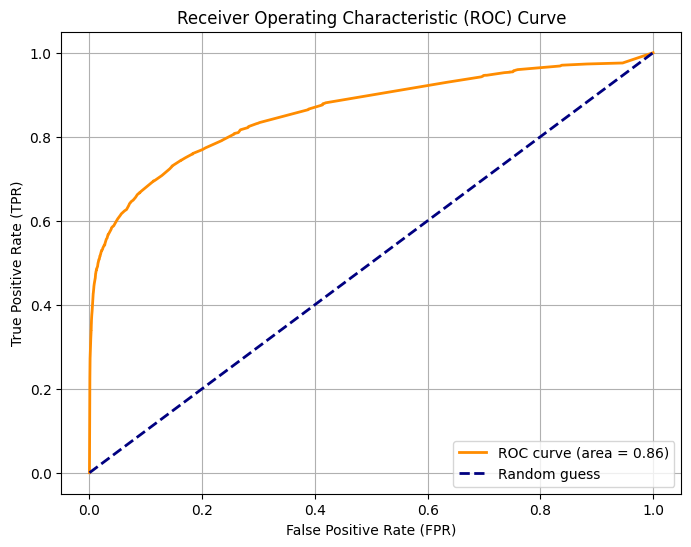

AUC: 0.86


In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {val_roc_auc:.2f}")

In [66]:
val_precision, val_recall, thresholds = precision_recall_curve(y_val, val_proba[:,1])
val_auc_pr = auc(val_recall, val_precision)
val_auc_pr

0.5097266698803449

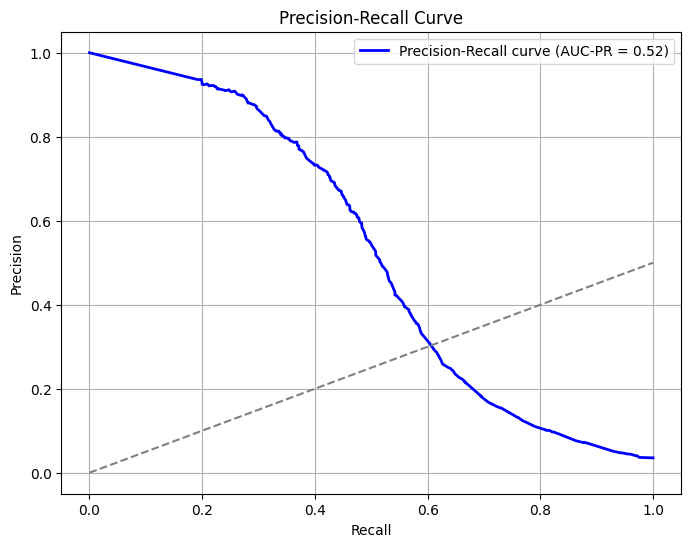

AUC-PR: 0.52


In [40]:
plt.figure(figsize=(8, 6))
plt.plot(val_recall,val_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {val_auc_pr:.2f}")

In [67]:
train_fpr, train_tpr, train_thresholds = roc_curve(y_train, train_proba[:,1])
train_roc_auc = auc(train_fpr, train_tpr)
train_roc_auc

0.9775573755623274

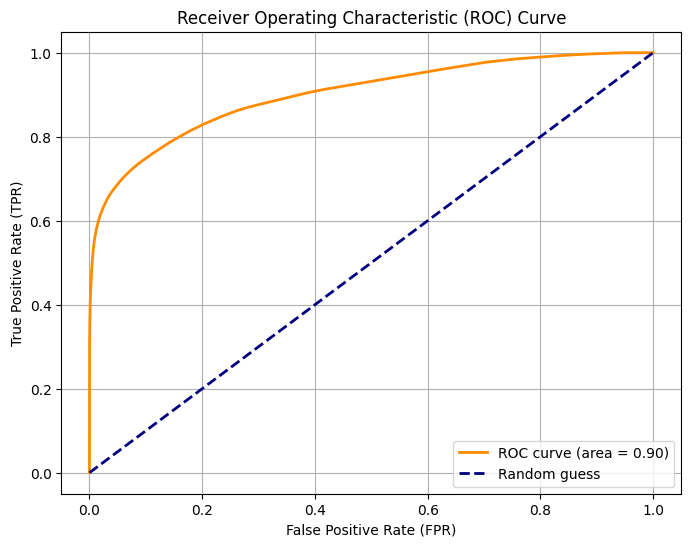

AUC: 0.90


In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# 8. Print the AUC value
print(f"AUC: {train_roc_auc:.2f}")

In [68]:
train_precision, train_recall, thresholds = precision_recall_curve(y_train, train_proba[:,1])
train_auc_pr = auc(train_recall, train_precision)
train_auc_pr

0.7025493920524032

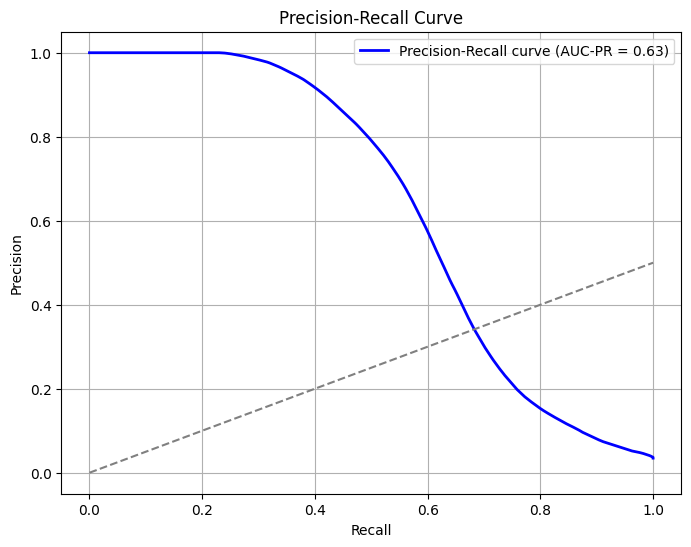

AUC-PR: 0.63


In [44]:
plt.figure(figsize=(8, 6))
plt.plot(train_recall,train_precision, color='b', lw=2,
         label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid()
plt.show()

print(f"AUC-PR: {train_auc_pr:.2f}")

In [45]:
!pip install -q dagshub mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.1/260.1 kB 6.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 50.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 75.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 692.3/692.3 kB 7.6 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.2/203.2 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.3/74.3 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 3.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are ins

In [46]:
import dagshub
dagshub.init(repo_owner='azhgh22', repo_name='ML2_fraud_detection', mlflow=True)

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=5d3fdfcf-5f1c-403e-b03b-41b007dd5fb4&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=6936542adf0f8a4da9ff88fd1aca3626a4252bd3da8aaea84bf60e16ce07810f




Output()

Accessing as azhgh22

Initialized MLflow to track repo "azhgh22/ML2_fraud_detection"

Repository azhgh22/ML2_fraud_detection initialized!

In [47]:
import mlflow
import seaborn as sns
import matplotlib.pyplot as plt

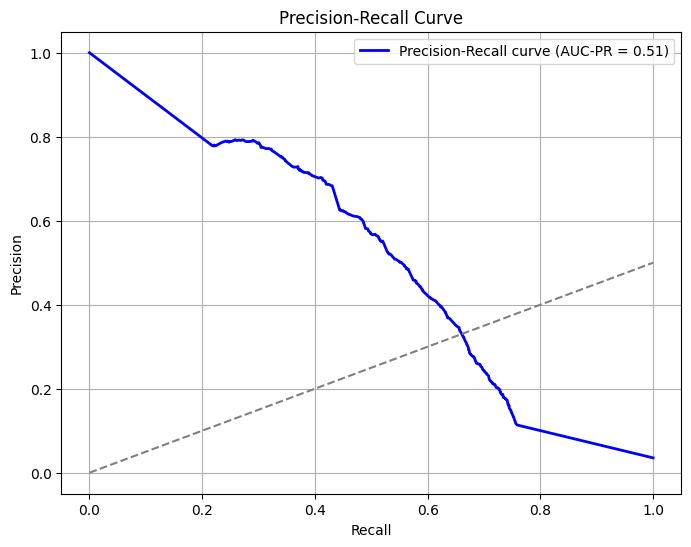

AUC-PR: 0.51


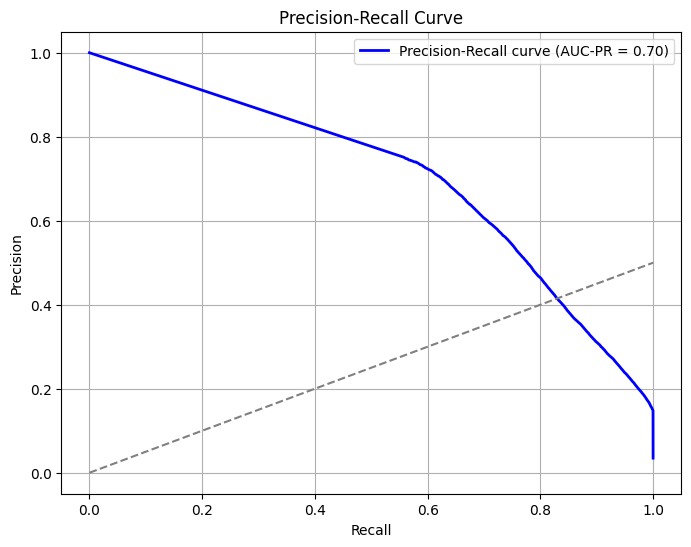

AUC-PR: 0.70


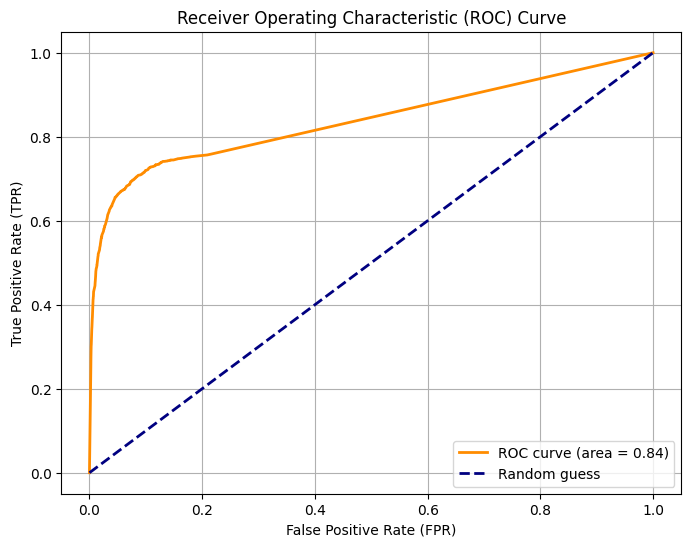

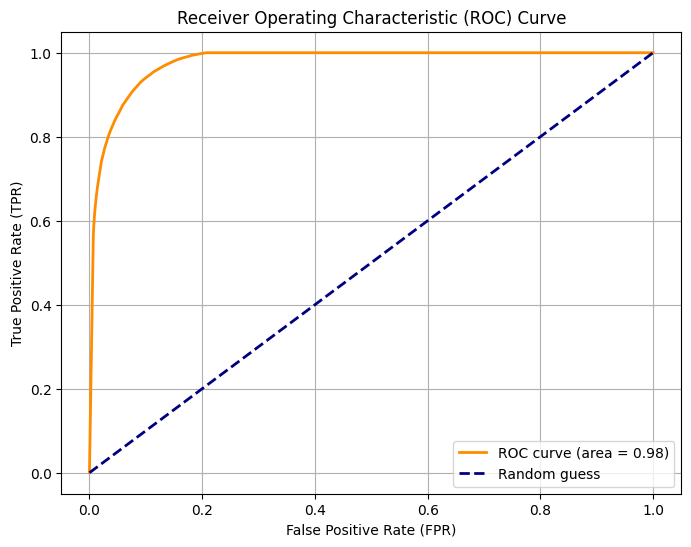

2025/04/27 08:52:45 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run dectree:run1 at: https://dagshub.com/azhgh22/ML2_fraud_detection.mlflow/#/experiments/3/runs/c36adfaf18f34d7ab34d8de6197d2350
🧪 View experiment at: https://dagshub.com/azhgh22/ML2_fraud_detection.mlflow/#/experiments/3


In [69]:
mlflow.set_experiment("Decision Tree")
with mlflow.start_run(run_name="dectree:run1"):
    mlflow.log_params({
        # 'CustomSelector' : ['TransactionID','id_05','id_06','id_09','id_10','id_11','id_17','id_18','id_22','id_24','id_25','id_32','id_27','id_36', 'id_37','DeviceInfo','M1'],
        'used_tables' : ['transaction.csv'],
        # 'join method' : {
        #       'on' : 'TransactionID',
        #       'how' : 'left'
        # },
        'cross_val_split': {
            # 'sortdby' : 'TransactionDT',
            'method' : 'test_train_split',
            'train' : 0.8,
            'validation' : 0.1,
            'test' : 0.1,
            'random_state' : 42
        },
        'variation_filter' : {
            'left_threshold' : 0.002,
            'right_threshold' : 85.00
        },
        'drop_na_heavy_columns_threshold' : 0.9,
        'na imputer' : 'SimpleImputer(strategy=\'most_drequent\')',
        # 'categorical columns' : {
        #     '>threshold' : 'woe',
        #     '<=threshold' : 'one_hot'
        # },
        'categorical columns' : 'target_encoder',
        # 'cat2num_threshold' : 5,
        'correlation filter threshold' : 0.98,
        'scaler' : 'StandardScaler',
        # 'LogisticFilter_threshold' : 0.015, 
        'imb_pipline_steps' : {
            'step1' : 'undersampling',
            'step2' : 'oversampling'
        },
        'undersampling' : {
            'class' : 'RandomUnderSampler',
            'random_state' : 42,
            'sampling_strategy' : 0.1
        },
        'oversampling' : {
            'class' : 'RandomOverSampler',
            'random_state' : 42,
            'sampling_strategy' : 0.4
        },
        'model' : 'DecisionTreeClassifier',
        'random_state' : 42,
        'max_depth' : 50,
        'min_samples_split' : 60
    })
    mlflow.log_metrics({
        'train_roc_auc': train_roc_auc,
        'test__roc_auc' : val_roc_auc, 
        'train_pr_auc' : train_auc_pr,
        'val_pr_auc' : val_auc_pr
    })

    plt.figure(figsize=(8, 6))
    plt.plot(val_recall,val_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {val_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("val_roc_pr.png")
    plt.show()
    mlflow.log_artifact("val_roc_pr.png")
    print(f"AUC-PR: {val_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(train_recall,train_precision, color='b', lw=2,
             label=f'Precision-Recall curve (AUC-PR = {train_auc_pr:.2f})')
    plt.plot([0, 1], [0, 0.5], color='gray', linestyle='--')  # Baseline
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend(loc='best')
    plt.grid()
    plt.savefig("train_roc_pr.png")
    plt.show()
    mlflow.log_artifact("train_roc_pr.png")
    print(f"AUC-PR: {train_auc_pr:.2f}")

    plt.figure(figsize=(8, 6))
    plt.plot(val_fpr, val_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % val_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("validation_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("validation_roc.png")

    plt.figure(figsize=(8, 6))
    plt.plot(train_fpr, train_tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % train_roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random guess')
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid()
    plt.savefig("train_roc.png")
    plt.show()
    plt.close()
    mlflow.log_artifact("train_roc.png")
    
    mlflow.sklearn.log_model(model,'xgboost_with_identity')
    
    mlflow.end_run()